# Visualizing the Covid-19 Pandemic

I've held off on creating a visualization of the pandemic so far because I think things have been [covered well](https://www.ft.com/content/a26fbf7e-48f8-11ea-aeb3-955839e06441) by [others](https://ourworldindata.org/coronavirus). But there are still a few visualizations that I'd like to see, so I decided to give it a try. When I look at a Covid-19 visualization, I generally want to answer a few questions:

* **How bad is it?** Total numbers are needed here to show the human toll.  
* **Is it getting worse?** Time series data is helpful here to put current data in context. Preferably show new cases rather than total cases on the y-axis so we can quickly see increases.    
* **How effective is our response?** Per capita numbers are useful here because they allow us to see how well governments are responding relative to each other.
* **How risky are things for me?** Per capita numbers are also helpful here because they're proportionate to individual risk. But individual risk can also be calculated using a model, which I do below. Either way, the numbers have to be at a small enough resolution (e.g. state or county) to matter for individuals. 

So I created a few visualizations to try to answer these questions. And just to get this out of the way at the start, I want to stress that I am not an epidemiologist (IANAE). But for the most part I'm communicating existing information rather than creating it, so this shouldn't be too much of a problem.

In [5]:
import os
from datetime import date, datetime, timedelta
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display

In [6]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [22]:
# Note, this shouldn't be run until mid day, not right when partial data is available.
# Because a mismatch in the data will cause problems. 
def get_data(archive_dir, date_str, sources):
    for label, source in sources.items():
        data = pd.read_csv(source['url'])
        out_path = os.path.join(archive_dir, source['local'].format(date_str))
        temp_path = os.path.join(archive_dir, source['local'].format('latest'))
        data.to_csv(out_path, index=False)
        data.to_csv(temp_path, index=False)

def load_data(archive_dir, date_str, sources):
    data = {}
    for label, source in sources.items():
        local_path = os.path.join(archive_dir, source['local'].format(date_str))
        print(label, ': ', source['local'].format(date_str))
        data[label] = pd.read_csv(local_path)
    return data

In [23]:
# Could also be an earlier string for retrospective analysis '2020-06-05'
date_str = '2020-06-12' #'2020-06-08' #date.today().isoformat() 
archive_dir = os.path.join(os.getcwd(), 'data', 'archive')

sources = {
    'world': {
        'url': 'https://covid.ourworldindata.org/data/owid-covid-data.csv',
        'local':'{0}-owid-world.csv',
    },
    'us': {
        'url': 'https://covidtracking.com/api/v1/states/daily.csv',
        'local': '{0}-covidtrackingproject-us.csv'
    }, 
    'statemodel': {
        'url': 'https://raw.githubusercontent.com/youyanggu/covid19_projections/master/projections/combined/latest_us.csv',
        'local': '{0}-covid19_projections-latest_us.csv'
    },
    'countymodel': {
        'url': 'https://raw.githubusercontent.com/youyanggu/covid19_projections/master/projections/combined/latest_subregion.csv',
        'local': '{0}-covid19_projections-latest_subregion.csv'
    } 
}

get_data(archive_dir, date_str, sources)  #Optional, comment out if using existing data
data = load_data(archive_dir, date_str, sources)

world :  2020-06-12-owid-world.csv
us :  2020-06-12-covidtrackingproject-us.csv
statemodel :  2020-06-12-covid19_projections-latest_us.csv
countymodel :  2020-06-12-covid19_projections-latest_subregion.csv


# Timeseries Visualization

In [24]:
world_df = data['world'].copy()
world_df = world_df[~world_df['location'].isin(['International', 'World'])]
world_df['date'] = pd.to_datetime(world_df['date'])
cols = ['iso_code', 'location', 'date', 'total_cases','total_deaths_per_million',
    'total_deaths', 'total_cases_per_million', 'new_cases', 'new_cases_per_million']
world_df = world_df[cols]
# 7 Day rolling average:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#groupby-transform-window-resample
# Ok, for modeling purposes 3d might be right, but for visualization purposes, 7d is right.
# But even for modeling, 7d might be better, because many country timeseries are showing weekly variation
# in when they report cases using a 3 day smoothing.
world_df = world_df.groupby(by=['iso_code', 'location']) \
    .rolling(window='7d', on='date') \
    .agg({'total_cases': 'max', 'total_cases_per_million': 'max', 'total_deaths': 'max',
        'total_deaths_per_million': 'max', 'new_cases': 'mean', 'new_cases_per_million': 'mean'})

#Clip for log visualization purposes
world_df['new_cases_per_million'] = world_df.new_cases_per_million.clip(lower=0.1)
world_df = world_df.reset_index(drop=False)
display(world_df)

iso_code  location       date  total_cases  total_cases_per_million  \
0          ABW     Aruba 2020-03-13          2.0                   18.733   
1          ABW     Aruba 2020-03-20          4.0                   37.465   
2          ABW     Aruba 2020-03-24         12.0                  112.395   
3          ABW     Aruba 2020-03-25         17.0                  159.227   
4          ABW     Aruba 2020-03-26         19.0                  177.959   
...        ...       ...        ...          ...                      ...   
23159      ZWE  Zimbabwe 2020-06-08        282.0                   18.973   
23160      ZWE  Zimbabwe 2020-06-09        287.0                   19.310   
23161      ZWE  Zimbabwe 2020-06-10        314.0                   21.126   
23162      ZWE  Zimbabwe 2020-06-11        320.0                   21.530   
23163      ZWE  Zimbabwe 2020-06-12        332.0                   22.337   

       total_deaths  total_deaths_per_million  new_cases  \
0               0.0                     0.000   2.000000   
1               0.0                     0.000   2.000000   
2               0.0                     0.000   5.000000   
3               0.0                     0.000   5.000000   
4               0.0                     0.000   4.250000   
...             ...                       ...        ...   
23159           4.0                     0.269  14.857143   
23160           4.0                     0.269  12.000000   
23161           4.0                     0.269  15.428571   
23162           4.0                     0.269  14.000000   
23163           4.0                     0.269  13.571429   

       new_cases_per_million  
0                  18.733000  
1                  18.733000  
2                  46.831500  
3                  46.831333  
4                  39.806750  
...                      ...  
23159               0.999714  
23160               0.807429  
23161               1.038143  
23162               0.942000  
23163               0.913143  

[23164 rows x 9 columns]

In [25]:
# https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-total.html
statepop_df = pd.read_csv(os.path.join(os.getcwd(), 'data','state_population.csv'))
statepop_df.head(5)

state_abbr       state  population
0         AL     Alabama     4903185
1         AK      Alaska      731545
2         AZ     Arizona     7278717
3         AR    Arkansas     3017804
4         CA  California    39512223

In [26]:
us_df = data['us'].copy()
# Note: 'positive' is the total positive count, positiveIncrease is that day's increase in cases.
cols = ['date', 'state', 'positive', 'positiveIncrease', 'death', 'deathIncrease']
us_df = us_df[cols]
us_df = us_df[~us_df[['positive', 'positiveIncrease', 'death', 'deathIncrease']].isnull().any(1)]
us_df['date'] = pd.to_datetime(us_df['date'], format='%Y%m%d')
us_df.rename(columns={'state': 'state_abbr', 'positive': 'total_cases',
    'positiveIncrease':'new_cases', 'deathIncrease': 'new_deaths',
    'death': 'total_deaths'}, inplace=True)
us_df = us_df.merge(statepop_df, on='state_abbr')
us_df['total_cases_per_million'] = (us_df['total_cases']/us_df['population'])*1000000
us_df['new_cases_per_million'] = (us_df['new_cases']/us_df['population'])*1000000
us_df['total_deaths_per_million'] = (us_df['total_deaths']/us_df['population'])*1000000
us_df = us_df[['date', 'state_abbr','state', 'total_cases', 'new_cases',
    'total_cases_per_million', 'new_cases_per_million', 'new_deaths', 'total_deaths', 
    'total_deaths_per_million']]
us_df.rename(columns={'state_abbr':'iso_code', 'state':'location'}, inplace=True)
us_df = us_df.sort_values(by='date', ascending=True)

# Smooth with rolling average
# https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#groupby-transform-window-resample
us_df = us_df.groupby(by=['iso_code', 'location']) \
    .rolling(window='7d', on='date') \
    .agg({'total_cases': 'max', 'total_cases_per_million': 'max', 'total_deaths': 'max',
        'total_deaths_per_million': 'max','new_deaths': 'mean', 
        'new_cases': 'mean', 'new_cases_per_million': 'mean'})
#Clip after aggregation, for log plot purposes
us_df['new_cases_per_million'] = us_df['new_cases_per_million'].clip(lower=0.1)

us_df.reset_index(drop=False, inplace=True)
display(us_df)

iso_code location       date  total_cases  total_cases_per_million  \
0          AK   Alaska 2020-03-06          0.0                 0.000000   
1          AK   Alaska 2020-03-07          0.0                 0.000000   
2          AK   Alaska 2020-03-08          0.0                 0.000000   
3          AK   Alaska 2020-03-09          0.0                 0.000000   
4          AK   Alaska 2020-03-10          0.0                 0.000000   
...       ...      ...        ...          ...                      ...   
4446       WY  Wyoming 2020-06-08        960.0              1658.721506   
4447       WY  Wyoming 2020-06-09        970.0              1675.999855   
4448       WY  Wyoming 2020-06-10        980.0              1693.278204   
4449       WY  Wyoming 2020-06-11       1009.0              1743.385416   
4450       WY  Wyoming 2020-06-12       1027.0              1774.486444   

      total_deaths  total_deaths_per_million  new_deaths  new_cases  \
0              0.0                  0.000000    0.000000   0.000000   
1              0.0                  0.000000    0.000000   0.000000   
2              0.0                  0.000000    0.000000   0.000000   
3              0.0                  0.000000    0.000000   0.000000   
4              0.0                  0.000000    0.000000   0.000000   
...            ...                       ...         ...        ...   
4446          17.0                 29.373193    0.000000   7.142857   
4447          17.0                 29.373193    0.000000   8.571429   
4448          18.0                 31.101028    0.142857   9.285714   
4449          18.0                 31.101028    0.142857  13.428571   
4450          18.0                 31.101028    0.142857  13.428571   

      new_cases_per_million  
0                  0.100000  
1                  0.100000  
2                  0.100000  
3                  0.100000  
4                  0.100000  
...                     ...  
4446              12.341678  
4447              14.810013  
4448              16.044181  
4449              23.202354  
4450              23.202354  

[4451 rows x 10 columns]

In [27]:
def timeseries_chart(df, y, line_quantile, tooltip, title, width, height):
    since_df = df.copy()
    since_df = since_df[since_df['total_cases'] > 100] #total_cases_per_million > 1, total_cases > 100 ['new_cases_per_million'] > 1

    min_df = since_df.groupby(by=['iso_code']).agg({'date':'min'})
    min_df.rename(columns={'date':'min_date'}, inplace=True)
    # Merge back on, using right outer join to eliminate countries not past 100 cases yet
    since_df = since_df.merge(min_df, on='iso_code', how='right')
    since_df['days_since'] = since_df.date - since_df.min_date
    since_df['days_since'] = since_df['days_since'].apply(lambda x: x.days)
 
    lines_df = since_df.copy()
    # https://stackoverflow.com/a/54041328
    points_df = lines_df.sort_values(by='days_since', ascending=True) \
        .groupby(['iso_code', 'location']) \
        .tail(1)
    top = lines_df.groupby(by=['iso_code']).agg({'total_cases':'max'})
    top.reset_index(drop=False, inplace=True)
    top = top[top.total_cases >= top.total_cases.quantile(line_quantile)]['iso_code']
    lines_df = lines_df[lines_df.iso_code.isin(top)]

    #scale=alt.Scale()
    #x_domain = [points_df['total_cases_per_million'].min(), points_df['total_cases_per_million'].max()]
    #y_domain = [points_df['new_cases_per_million'].min(), points_df['new_cases_per_million'].max()]
    y_domain = [points_df[y].min(), points_df[y].max()]
    #y_domain = [lines_df[y].min(), lines_df[y].max()]
    #y_scale=alt.Scale(domain=y_domain)
    y_scale=alt.Scale(type='log', domain=y_domain, base=10) #10
    y_axis=alt.Y('{0}:Q'.format(y), scale=y_scale, title='New cases per million')
    #x_domain = [max([0, points_df['days_since'].min()-5]), points_df['days_since'].max()]
    #x_scale=alt.Scale()
    x_axis=alt.X('days_since:Q', title='Days since 100 cases') #scale=x_scale
    #y=alt.Y('new_cases:Q', scale=scale) #scale=alt.Scale(type='log')

    # https://altair-viz.github.io/gallery/multiline_highlight.html
    highlight = alt.selection(type='single', on='mouseover', fields=['location']) #, nearest=True

    timeseries_lines = alt.Chart(lines_df).mark_line(
        interpolate='basis',
        color='gray'
    ).encode(
        x=x_axis,
        y=y_axis,
        order='days_since:Q',
        detail='location:N',
        opacity=alt.condition(~highlight, alt.value(0.2), alt.value(1.0))
    )
    
    dot_str = 'total_deaths:Q' # total_deaths:Q total_cases:Q

    timeseries_points = alt.Chart(points_df).mark_point().encode(
        x=x_axis,
        y=y_axis,
        size=alt.Size(dot_str, scale=alt.Scale(range=[50,4000]), legend=alt.Legend(clipHeight=15)),
        color=alt.Color(dot_str, scale=alt.Scale(scheme='goldred')),
        fill=alt.Color(dot_str, scale=alt.Scale(scheme='goldred')),
        opacity=alt.condition(~highlight, alt.value(0.75), alt.value(0.9)),
        order=alt.Order(dot_str, sort="descending"),
        tooltip=tooltip
    )

    # https://stackoverflow.com/questions/57560694/how-do-i-set-label-text-size-in-altair
    text = alt.Chart(points_df).mark_text(
        align='center',
        baseline='middle',
        size=9
    ).encode(
        x=x_axis,
        y=y_axis,
        text='iso_code:N'
    )

    timeseries_chart = (timeseries_points + text + timeseries_lines).properties(
        title=title,
        width=width,  #700  600  800
        height=height #500  450  600
#         width='container', #https://stackoverflow.com/a/59580645
#         height='container'
    ).interactive().add_selection(highlight)
    
    return timeseries_chart

In [28]:
world_tooltip=[
    alt.Tooltip('location:N'),
    alt.Tooltip('date:T'),
    alt.Tooltip('new_cases:Q', format=',.0f'),
    alt.Tooltip('new_cases_per_million:Q', format=',.1f'),
    alt.Tooltip('total_cases:Q', format=',.0f'),
    alt.Tooltip('total_cases_per_million:Q', format=',.0f'),
    alt.Tooltip('total_deaths:Q', format=',.0f'),
    alt.Tooltip('total_deaths_per_million:Q', format=',.0f')
]
world_timeseries = timeseries_chart(
    world_df, 
    y='new_cases_per_million',
    line_quantile=0.65, tooltip=world_tooltip,
    title='New Covid-19 cases per million, World, {0}'.format(date_str),
    width=800,
    height=550
)
#world_timeseries.save('world.html')
display(world_timeseries)

alt.LayerChart(...)

In [29]:
us_tooltip=[
    alt.Tooltip('location:N'),
    alt.Tooltip('date:T'),
    alt.Tooltip('new_cases:Q', format=',.0f'),
    alt.Tooltip('new_cases_per_million:Q', format=',.0f'),
    alt.Tooltip('total_cases:Q', format=',.0f'),
    alt.Tooltip('total_cases_per_million:Q', format=',.0f'),
    alt.Tooltip('total_deaths:Q', format=',.0f'),
    alt.Tooltip('total_deaths_per_million:Q', format=',.0f')
]
us_timeseries = timeseries_chart(
    us_df,
    y='new_cases_per_million',
    line_quantile=0, 
    tooltip=us_tooltip,
    title='New Covid-19 cases per million, US, {0}'.format(date_str),
    width=800,
    height=550
)
display(us_timeseries)

alt.LayerChart(...)

# What's the probability a person has Covid-19?

In [30]:
# https://stackoverflow.com/questions/19699367
countypop_df = pd.read_csv(os.path.join(os.getcwd(), 'data', 'co-est2019-alldata.csv'), 
    encoding = "ISO-8859-1")
countypop_df = countypop_df[['STNAME', 'CTYNAME', 'POPESTIMATE2019']]
countypop_df.rename(columns={'STNAME': 'state', 'CTYNAME': 'county', 
    'POPESTIMATE2019':'population'}, inplace=True)
countypop_df = countypop_df.merge(statepop_df[['state_abbr', 'state']], on='state')
# https://en.wikipedia.org/wiki/List_of_counties_in_New_York
# Five of New York's counties are each coextensive with New York City's five boroughs and 
# do not have county governments. They are New York County (Manhattan), Kings County (Brooklyn),
# Bronx County (The Bronx), Richmond County (Staten Island), and Queens County (Queens). 
nyc_df = countypop_df[countypop_df['county'].isin(['New York County', 'Kings County',
    'Bronx County', 'Richmond County', 'Queens County'])]
nyc_df = pd.DataFrame({'state': ['New York'], 'county': ['New York City County'],
    'population': [nyc_df['population'].sum()], 'state_abbr': ['NY']})
countypop_df = pd.concat([countypop_df, nyc_df])
countypop_df.head(5)

state          county  population state_abbr
0  Alabama         Alabama     4903185         AL
1  Alabama  Autauga County       55869         AL
2  Alabama  Baldwin County      223234         AL
3  Alabama  Barbour County       24686         AL
4  Alabama     Bibb County       22394         AL

In [31]:
statemodel_df = data['statemodel'].copy()
statemodel_df = statemodel_df[['date', 'region','actual_deaths', 'total_deaths', 'subregion', 
    'predicted_deaths_mean', 'predicted_total_deaths_mean','predicted_new_infected_mean',
    'predicted_current_infected_mean', 'predicted_total_infected_mean']]
statemodel_df = statemodel_df[~statemodel_df.region.isnull()]
statemodel_df.rename(columns={'region':'state_abbr'}, inplace=True)
statemodel_df = statemodel_df.merge(statepop_df, on='state_abbr')
statemodel_df['probability_infected'] = (statemodel_df['predicted_current_infected_mean']/
    statemodel_df['population'])
statemodel_df['predicted_new_infected_per_million'] = (statemodel_df['predicted_new_infected_mean']/
    statemodel_df['population'])*1000000
statemodel_df['date'] = pd.to_datetime(statemodel_df['date'])
statemodel_df.rename(columns={'state':'location', 'state_abbr': 'abbr',
    'predicted_new_infected_mean':'pred_new_infected_mean',
    'predicted_new_infected_per_million':'pred_new_infected_per_mil'}, inplace=True)
statemodel_df =  statemodel_df[['date', 'total_deaths', 'location', 'abbr', 'probability_infected',
    'pred_new_infected_mean', 'pred_new_infected_per_mil']] 

statemodel_df = statemodel_df[statemodel_df.date < date_str]
display(statemodel_df)

date  total_deaths location abbr  probability_infected  \
0     2020-03-01           NaN   Alaska   AK              0.000014   
1     2020-03-02           NaN   Alaska   AK              0.000029   
2     2020-03-03           NaN   Alaska   AK              0.000042   
3     2020-03-04           NaN   Alaska   AK              0.000056   
4     2020-03-05           NaN   Alaska   AK              0.000071   
...          ...           ...      ...  ...                   ...   
11111 2020-06-07          17.0  Wyoming   WY              0.000826   
11112 2020-06-08          17.0  Wyoming   WY              0.000819   
11113 2020-06-09          17.0  Wyoming   WY              0.000810   
11114 2020-06-10          18.0  Wyoming   WY              0.000802   
11115 2020-06-11          18.0  Wyoming   WY              0.000791   

       pred_new_infected_mean  pred_new_infected_per_mil  
0                        10.0                  13.669699  
1                        10.0                  13.669699  
2                        10.0                  13.669699  
3                        10.0                  13.669699  
4                        10.0                  13.669699  
...                       ...                        ...  
11111                    30.0                  51.835047  
11112                    29.0                  50.107212  
11113                    29.0                  50.107212  
11114                    28.0                  48.379377  
11115                    27.0                  46.651542  

[5516 rows x 7 columns]

In [32]:
countymodel_df = data['countymodel'].copy()
countymodel_df = countymodel_df[countymodel_df['country'] == 'US']

countymodel_df = countymodel_df[['date', 'country', 'region', 'subregion','actual_deaths', 'total_deaths', 
    'predicted_deaths_mean', 'predicted_total_deaths_mean','predicted_new_infected_mean',
    'predicted_current_infected_mean', 'predicted_total_infected_mean']]
countymodel_df = countymodel_df[~countymodel_df.subregion.isnull()]
countymodel_df.rename(columns={'region':'state_abbr', 'subregion':'county'}, inplace=True)
countymodel_df['abbr'] = countymodel_df['county']

countymodel_df['county'] = countymodel_df['county'] + ' County'
countymodel_df = countymodel_df.merge(countypop_df, on=['county', 'state_abbr'], how='left')

countymodel_df['probability_infected'] = (countymodel_df['predicted_current_infected_mean']/
    countymodel_df['population'])
countymodel_df['predicted_new_infected_per_million'] = (countymodel_df['predicted_new_infected_mean']/
    countymodel_df['population'])*1000000
countymodel_df['date'] = pd.to_datetime(countymodel_df['date'])
countymodel_df = countymodel_df[countymodel_df.date < date_str]
countymodel_df.rename(columns={'county':'location', 
    'predicted_new_infected_mean':'pred_new_infected_mean',
    'predicted_new_infected_per_million':'pred_new_infected_per_mil'}, inplace=True)
#Make location a unique identifier
countymodel_df['location'] = countymodel_df['location'] + ', ' + countymodel_df['state_abbr']

countymodel_df =  countymodel_df[['date','state_abbr', 'location','abbr', 'actual_deaths', 'total_deaths', 
    'probability_infected','pred_new_infected_mean', 'pred_new_infected_per_mil']]

display(countymodel_df)

date state_abbr             location      abbr  actual_deaths  \
0    2020-02-27         AZ  Maricopa County, AZ  Maricopa            NaN   
1    2020-02-28         AZ  Maricopa County, AZ  Maricopa            NaN   
2    2020-02-29         AZ  Maricopa County, AZ  Maricopa            NaN   
3    2020-03-01         AZ  Maricopa County, AZ  Maricopa            NaN   
4    2020-03-02         AZ  Maricopa County, AZ  Maricopa            NaN   
...         ...        ...                  ...       ...            ...   
7290 2020-06-07         WA      King County, WA      King            2.0   
7291 2020-06-08         WA      King County, WA      King            1.0   
7292 2020-06-09         WA      King County, WA      King            1.0   
7293 2020-06-10         WA      King County, WA      King            0.0   
7294 2020-06-11         WA      King County, WA      King            3.0   

      total_deaths  probability_infected  pred_new_infected_mean  \
0              NaN              0.000021                      95   
1              NaN              0.000042                      95   
2              NaN              0.000064                      95   
3              NaN              0.000085                      95   
4              NaN              0.000106                      95   
...            ...                   ...                     ...   
7290         578.0              0.001390                     186   
7291         579.0              0.001364                     186   
7292         580.0              0.001340                     186   
7293         580.0              0.001320                     186   
7294         583.0              0.001302                     187   

      pred_new_infected_per_mil  
0                     21.179762  
1                     21.179762  
2                     21.179762  
3                     21.179762  
4                     21.179762  
...                         ...  
7290                  82.564580  
7291                  82.564580  
7292                  82.564580  
7293                  82.564580  
7294                  83.008476  

[3599 rows x 9 columns]

In [33]:
def model_timeseries_chart(df, y, line_quantile, tooltip, title):
    since_df = df.copy()
    #total_cases_per_million > 1, total_cases > 100 'new_cases_per_million' > 1
    since_df = since_df[since_df['pred_new_infected_mean'] > 100]
    
    #['abbr'], ['abbr', 'state_abbr]
    min_df = since_df.groupby(by=['location']).agg({'date':'min'})
    min_df.rename(columns={'date':'min_date'}, inplace=True)
    # Merge back on, using right outer join to eliminate countries not past 100 cases yet
    since_df = since_df.merge(min_df, on='location', how='right') #'abbbr'
    since_df['days_since'] = since_df.date - since_df.min_date
    since_df['days_since'] = since_df['days_since'].apply(lambda x: x.days)
    since_df.reset_index(drop=False, inplace=True)
 
    lines_df = since_df.copy()
    # https://stackoverflow.com/a/54041328
    points_df = lines_df.sort_values(by='days_since', ascending=True) \
        .groupby(['location']) \
        .tail(1)
    top = lines_df.groupby(by=['location']).agg({'total_deaths':'max'})
    top.reset_index(drop=False, inplace=True)
    top = top[top.total_deaths >= top.total_deaths.quantile(line_quantile)]['location']
    lines_df = lines_df[lines_df['location'].isin(top)]

    y_domain = [points_df[y].min(), points_df[y].max()]
    #y_domain = [lines_df[y].min(), lines_df[y].max()]
    #y_scale=alt.Scale(domain=y_domain)
    y_scale=alt.Scale(type='log', domain=y_domain, base=10) #10
    # if y_fmt:
    #     y_axis=alt.Y('{0}:Q'.format(y), scale=y_scale, axis=alt.Axis(format=y_fmt))
    # else:
    y_axis=alt.Y('{0}:Q'.format(y), scale=y_scale, axis=alt.Axis(format='%'),
        title='Probability Infected')  #
    #x_domain = [max([0, points_df['days_since'].min()-5]), points_df['days_since'].max()]
    #x_scale=alt.Scale(domain=x_domain)
    x_axis=alt.X('days_since:Q', title='Days since 100 cases') #scale=x_scale 
    #y=alt.Y('new_cases:Q', scale=scale) #scale=alt.Scale(type='log')

    # https://altair-viz.github.io/gallery/multiline_highlight.html
    highlight = alt.selection(type='single', on='mouseover', fields=['location']) #, nearest=True
    
    timeseries_lines = alt.Chart(lines_df).mark_line(
        interpolate='basis',
        color='gray'
    ).encode(
        x=x_axis,
        y=y_axis,
        order='days_since:Q',
        detail='location:N',
        opacity=alt.condition(~highlight, alt.value(0.2), alt.value(1.0))
    )
    
    dot_str = 'total_deaths:Q' # total_deaths:Q total_cases:Q

    timeseries_points = alt.Chart(points_df).mark_point().encode(
        x=x_axis,
        y=y_axis,
        size=alt.Size(dot_str, scale=alt.Scale(range=[50,4000]), legend=alt.Legend(clipHeight=15)),
        color=alt.Color(dot_str, scale=alt.Scale(scheme='goldred')),
        fill=alt.Color(dot_str, scale=alt.Scale(scheme='goldred')),
        opacity=alt.condition(~highlight, alt.value(0.75), alt.value(0.9)),
        order=alt.Order(dot_str, sort="descending"),
        tooltip=tooltip
    )

    # https://stackoverflow.com/questions/57560694/how-do-i-set-label-text-size-in-altair
    text = alt.Chart(points_df).mark_text(
        align='center',
        baseline='middle',
        #opacity=0.9,
        size=9
    ).encode(
        x=x_axis,
        y=y_axis,
        #text='location:N' #iso_code
        text='abbr:N' #iso_code
    )

    timeseries_chart = (timeseries_points + text + timeseries_lines).properties(
        title=title,
#         width='container', # https://stackoverflow.com/a/59580645
#         height='container'
        width=800,  #700  600  800
        height=550, #500  450  600
    ).interactive().add_selection(highlight)
    
    return timeseries_chart

In [34]:
# New taxonomy: abbreviation is the label on the plot
# location is the bubble label

statemodel_tooltip=[
    alt.Tooltip('location:N'),
    alt.Tooltip('date:T'),
    alt.Tooltip('probability_infected:Q', format=',.2%'),
    alt.Tooltip('total_deaths:Q', format=',.0f'),
    alt.Tooltip('pred_new_infected_mean:Q', format=',.0f'),
    alt.Tooltip('pred_new_infected_per_mil:Q', format=',.0f')
]

statemodel_timeseries = model_timeseries_chart(
    statemodel_df, 
    y='probability_infected',
    line_quantile=0, 
    tooltip=statemodel_tooltip,
    title='Probability Infected, US, {0}'.format(date_str)
)
display(statemodel_timeseries)

alt.LayerChart(...)

In [35]:
countymodel_tooltip=[
    alt.Tooltip('location:N'),
    alt.Tooltip('date:T'),
    alt.Tooltip('probability_infected:Q', format=',.2%'),
    alt.Tooltip('total_deaths:Q', format=',.0f'),
    alt.Tooltip('pred_new_infected_mean:Q', format=',.0f'),
    alt.Tooltip('pred_new_infected_per_mil:Q', format=',.0f')
]

countymodel_timeseries = model_timeseries_chart(countymodel_df, y='probability_infected',
    line_quantile=0, tooltip=countymodel_tooltip,
    title='Probability Infected, US Counties, {0}'.format(date_str)) #0.8
display(countymodel_timeseries)

alt.LayerChart(...)

In [36]:
cols = ['date','location','state_abbr','total_deaths',
    'pred_new_infected_per_mil', 'probability_infected']

statetable_df = statemodel_df.sort_values(by='date', ascending=True) \
    .groupby(by=['location']) \
    .tail(1)
statetable_df.rename(columns={'abbr':'state_abbr'}, inplace=True)

countytable_df = countymodel_df.sort_values(by='date', ascending=True) \
    .groupby(by=['state_abbr', 'location']) \
    .tail(1)

table_df = pd.concat([statetable_df[cols], countytable_df[cols]])
table_df = table_df[~table_df.isnull().any(1)]
table_df = table_df.sort_values(by='probability_infected', ascending=False)
table_df['probability_infected'] = table_df['probability_infected']*100
table_df['date'] = table_df['date'].dt.date
table_df.reset_index(drop=True, inplace=True)
#table_df = pd.DataFrame.round(table_df, decimals=2)
table_df = table_df.round(2)
out_table = table_df.style.background_gradient(cmap='Reds').set_precision(2).render()
#out = html_str.format(out)
table_df.style.background_gradient(cmap='Reds').set_precision(2)

In [45]:
# Optional output
output = True
if output:
    out_dir = '/Users/psthomas/Documents/projects/pstblog/psthomas.github.io/vis'
    table_path = os.path.join(out_dir, 'covid-table.html')
    with open(table_path, 'w') as f:
        f.write(out_table)

#     out_labels = {
#         'covid-world.json': world_timeseries,
#         'covid-us.json': us_timeseries,
#         'covid-us-model.json': statemodel_timeseries,
#         'covid-county-model.json': countymodel_timeseries   
#     }
    out_labels = {
        'covid-world.html': world_timeseries,
        'covid-us.html': us_timeseries,
        'covid-us-model.html': statemodel_timeseries,
        'covid-county-model.html': countymodel_timeseries   
    }

    for label, vis in out_labels.items():
        out_path = os.path.join(out_dir, label)
        #vis.properties(width='container', height='container')
        vis.save(out_path, embed_options={'actions': False})

# Basic Model Validation

## Comparing to Imperial

In [21]:
# https://mrc-ide.github.io/covid19usa/#/download
imperial_df = pd.read_csv('./data/imperial-model-estimates.csv')
imperial_df.rename(columns={'state':'abbr', 'predicted_infections_mean':'imperial_predicted_infections_mean'},
    inplace=True)
imperial_df['date'] = pd.to_datetime(imperial_df['date'])
imperial_df

abbr       date  reported_cases  imperial_predicted_infections_mean  \
0      AK 2020-04-06               5                           29.392160   
1      AK 2020-04-07              23                           29.392160   
2      AK 2020-04-08              13                           29.392160   
3      AK 2020-04-09               9                           29.392160   
4      AK 2020-04-10              11                           29.392160   
...   ...        ...             ...                                 ...   
4579   WY 2020-05-25               5                          186.151230   
4580   WY 2020-05-26               7                          284.770603   
4581   WY 2020-05-27              10                          299.883226   
4582   WY 2020-05-28              16                          332.966977   
4583   WY 2020-05-29              15                          359.844607   

      predicted_infections_lower_CI_95  \
0                             2.214298   
1                             2.214298   
2                             2.214298   
3                             2.214298   
4                             2.214298   
...                                ...   
4579                         11.432241   
4580                         15.120611   
4581                         14.241389   
4582                         13.938577   
4583                         13.277930   

      predicted_infections_higher_CI_95_cumulative  reported_deaths  \
0                                       103.053684                0   
1                                       103.053684                0   
2                                       103.053684                1   
3                                       103.053684                0   
4                                       103.053684                0   
...                                            ...              ...   
4579                                    793.213777                0   
4580                                   1266.137160                1   
4581                                   1391.519700                1   
4582                                   1613.964326                1   
4583                                   1833.484706                0   

      estimated_deaths_mean  estimated_deaths_lower_CI_95  \
0              2.939216e-14                  2.214298e-15   
1              4.086675e-07                  3.086923e-08   
2              8.377684e-06                  6.328191e-07   
3              4.822277e-05                  3.642569e-06   
4              2.069901e-04                  1.563526e-05   
...                     ...                           ...   
4579           6.586996e-01                  2.589160e-01   
4580           6.848042e-01                  2.658905e-01   
4581           7.138493e-01                  2.671388e-01   
4582           7.459338e-01                  2.688566e-01   
4583           7.813604e-01                  2.708967e-01   

      estimated_deaths_higher_CI_95  \
0                      1.030537e-13   
1                      1.441819e-06   
2                      2.955730e-05   
3                      1.701347e-04   
4                      7.302815e-04   
...                             ...   
4579                   1.296288e+00   
4580                   1.386606e+00   
4581                   1.492842e+00   
4582                   1.616271e+00   
4583                   1.763322e+00   

      mean_time_varying_reproduction_number_R(t)  \
0                                       0.708822   
1                                       0.693119   
2                                       0.704449   
3                                       0.715950   
4                                       0.711553   
...                                          ...   
4579                                    1.028849   
4580                                    1.449508   
4581                                    1.415258   
4582        

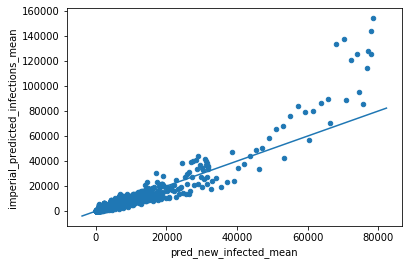

In [70]:
# The problem is that the new cases from the model_df is the actual reported new cases,
# because he doesn't project new cases after they've been realized. So I need to use his infection
# numbers to compare across. 
compare_df = imperial_df.merge(statemodel_df, on=['date', 'abbr'], how='left')
compare_df = compare_df.sort_values(by='date')
compare_df['ratio'] = compare_df['imperial_predicted_infections_mean']/compare_df['pred_new_infected_mean']

fig, ax = plt.subplots()
compare_df.plot(kind='scatter', x='pred_new_infected_mean', y='imperial_predicted_infections_mean', ax=ax)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x)

For a metric to compare them to a 45 degree line, maybe use Concordance correlation coefficient:
https://en.wikipedia.org/wiki/Concordance_correlation_coefficient. Values of ±1 denote perfect concordance and discordance; a value of zero denotes its complete absence. 

More info here: https://www.alexejgossmann.com/ccc/


    Looking at the above figures we see that the magnitude of the Pearson correlation coefficient ρ does not change under location and scale shift (though the sign may flip). The CCC on the other hand quantifies the deviation from the 45-degree line, which is due to location and scale shifts in these examples, rather well.

    This makes the CCC a better metric when we want to assess how well one measurement can reproduce another (i.e., how close the measurement pairs fall to the 45-degree line), while we would use ρ if what we want is quantifying to what extent the measurement pairs can be described by a linear equation (with any intercept and slope).

In [23]:
# Ok, that's actually pretty good, the mean ratio between the two is 1.06, which is pretty close to 1. 
# So there is a decently close correlation, but the high end values differ considerably.
# compare_df['ratio'].mean()
# 1.189955533881493

# This looks pretty good as well, concordance of 0.918 as of writing, 
# where 1 is the best, 0 is worst.
gu_series = compare_df['pred_new_infected_mean']
imperial_series = compare_df['imperial_predicted_infections_mean']

cov = gu_series.cov(imperial_series)
gu_mean = gu_series.mean()
gu_variance = gu_series.var()
imperial_mean = imperial_series.mean()
imperial_variance = imperial_series.var()
concordance_coef = (2*cov)/(gu_variance + imperial_variance + (gu_mean - imperial_mean)**2)
concordance_coef

0.916993917047143

## Spain sanity checks

Based on the total reported count, 0.5% of the nation has been infected as of 6/10/2020, while [serology says](https://www.vox.com/2020/5/16/21259492/covid-antibodies-spain-serology-study-coronavirus-immunity) 5%. So there's a 10x undercount of official cases. But, interestingly, the model predicts around 7.2% of Spain has been infected. So it's at least at the right order of magnitude, and it could be true depending on when the serology tests started.

So even though you'd expect a model minimizing error on an [undercount](https://www.economist.com/graphic-detail/2020/04/16/tracking-covid-19-excess-deaths-across-countries) of the death rate to undercount total infections as well, this doesn't seem to be the case. Maybe undercounting deaths is a problem during major upswing, but not during steady state spread?

In [28]:
spainmax = world_df[world_df['location'] == 'Spain']['total_cases'].max()
# https://en.wikipedia.org/wiki/Demographics_of_Spain
spainpop = 47007367
spainfraction = spainmax/spainpop
print('Total cases: ', spainmax)
print('Fraction reported infected: ', spainfraction)
# 6/10/2020
# Total cases:  241966.0
# Fraction reported infected:  0.00514740593745657

Total cases:  241966.0
Fraction reported infected:  0.00514740593745657


In [36]:
spainmodel_df = pd.read_csv('/Users/psthomas/Documents/projects/covid-vis/data/latest_global.csv')
spainmodelmax = spainmodel_df[spainmodel_df['country'] == 'Spain']['predicted_total_infected_mean'].max()
spainmodelfraction = spainmodelmax/spainpop
print('Total cases, modeled: ', spainmodelmax)
print('Fraction infected, model: ', spainmodelfraction)
# 6/10/2020
# Total cases, modeled:  3412609
# Fraction infected, model:  0.07259732288345357

Total cases, modeled:  3412609
Fraction infected, model:  0.07259732288345357
